목차

    ✔ 1단계: 데이터 불러오기 & 컬럼 영어 변환 & 날짜 정리
    ✔ 2단계: 결측치 체크 & 처리
    ✔ 3단계: 종가 기반 시계열 준비
    ✔ 4단계: 정상성 테스트 (ADF)
    ✔ 5단계: SARIMA
    ✔ 6단계: SARIMAX (외부변수)
    ✔ 7단계: 수익률 → GARCH
    ✔ 8단계: 수익률 → Sharpe Ratio
    ✔ 9단계: 예측 결과 시각화 + 해석

In [1]:
import pandas as pd

# 1️⃣ 데이터 불러오기
krx_auto = pd.read_csv('~/iffel/data/KRX_Automobile.csv', encoding='cp949')
kospi = pd.read_csv('~/iffel/data/KOSPI.csv', encoding='cp949')
hyundai = pd.read_csv('~/iffel/data/hyundai.csv', encoding='cp949')
kia = pd.read_csv('~/iffel/data/kia.csv', encoding='cp949')

# 컬럼 영어로 변환
rename_map_basic = {
    '일자': 'date',
    '종가': 'Closing Price',
    '대비': 'Change',
    '등락률': 'Fluctuation Rate',
    '시가': 'Opening Price',
    '고가': 'High Price',
    '저가': 'Low Price',
    '거래량': 'Trading Volume',
    '거래대금': 'Trading Value',
    '상장시가총액': 'Market Capitalization'
}

krx_auto.rename(columns=rename_map_basic, inplace=True)
kospi.rename(columns=rename_map_basic, inplace=True)

# 현대 (시총/주식수 컬럼명이 다름)
hyundai.rename(columns={
    '일자': 'date',
    '종가': 'Closing Price',
    '대비': 'Change',
    '등락률': 'Fluctuation Rate',
    '시가': 'Opening Price',
    '고가': 'High Price',
    '저가': 'Low Price',
    '거래량': 'Trading Volume',
    '거래대금': 'Trading Value',
    '시가총액': 'Market Capitalization',
    '상장주식수': 'Number of Listed shares'
}, inplace=True)

# 기아 (현대와 동일 구조)
kia.rename(columns={
    '일자': 'date',
    '종가': 'Closing Price',
    '대비': 'Change',
    '등락률': 'Fluctuation Rate',
    '시가': 'Opening Price',
    '고가': 'High Price',
    '저가': 'Low Price',
    '거래량': 'Trading Volume',
    '거래대금': 'Trading Value',
    '시가총액': 'Market Capitalization',
    '상장주식수': 'Number of Listed shares'
}, inplace=True)

# 날짜 타입 변환 + 정렬 + 인덱스 정리
for df in [krx_auto, kospi, hyundai, kia]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)

⭐ 2단계: 결측치 체크 & 처리

너의 4개 데이터셋(현대, 기아, 자동차섹터, 코스피)에서
**결측치(NaN)**가 있는지 확인하고,
필요하면 제거(drop) 또는 **채우기(fill)**를 해주면 돼.

✔ 2단계 목표

각 컬럼에 NaN 있는지 확인

이상치(ex. 음수 가격, 음수 거래량) 여부 체크

필요하면 제거

In [2]:
# 2️⃣ 결측치 확인
print("=== KRX Auto Missing ===")
print(krx_auto.isnull().sum())

print("\n=== KOSPI Missing ===")
print(kospi.isnull().sum())

print("\n=== Hyundai Missing ===")
print(hyundai.isnull().sum())

print("\n=== Kia Missing ===")
print(kia.isnull().sum())


=== KRX Auto Missing ===
date                     0
Closing Price            0
Change                   0
Fluctuation Rate         0
Opening Price            0
High Price               0
Low Price                0
Trading Volume           0
Trading Value            0
Market Capitalization    0
dtype: int64

=== KOSPI Missing ===
date                     0
Closing Price            0
Change                   0
Fluctuation Rate         0
Opening Price            0
High Price               0
Low Price                0
Trading Volume           0
Trading Value            0
Market Capitalization    0
dtype: int64

=== Hyundai Missing ===
date                       0
Closing Price              0
Change                     0
Fluctuation Rate           0
Opening Price              0
High Price                 0
Low Price                  0
Trading Volume             0
Trading Value              0
Market Capitalization      0
Number of Listed shares    0
dtype: int64

=== Kia Missing ===
date    

In [3]:
# 가격 0 제거

for df in [krx_auto, kospi, hyundai, kia]:
    df = df[df['Closing Price'] > 0]

⭐ 3단계: 종가 기반 시계열 준비

예측 모델(SARIMA, SARIMAX, GARCH)은 모두
시간 순서대로 정렬된 ‘종가(Closing Price)’ 시계열을 사용해.

따라서 지금 단계에서는:

✔ 목적

분석용 종가 시계열을 따로 생성

date 컬럼을 인덱스로 설정

플로팅해서 정상적으로 들어갔는지 확인

In [4]:
# 3️⃣ 종가 시계열 준비

# date를 인덱스로 설정
krx_auto_ts = krx_auto.set_index('date')['Closing Price']
kospi_ts = kospi.set_index('date')['Closing Price']
hyundai_ts = hyundai.set_index('date')['Closing Price']
kia_ts = kia.set_index('date')['Closing Price']

# 간단히 확인
print(krx_auto_ts.head())
print(hyundai_ts.head())

date
2023-11-01    1693.05
2023-11-02    1730.67
2023-11-03    1734.19
2023-11-06    1803.11
2023-11-07    1768.82
Name: Closing Price, dtype: float64
date
2023-11-01    170300
2023-11-02    172000
2023-11-03    173400
2023-11-06    177900
2023-11-07    176100
Name: Closing Price, dtype: int64


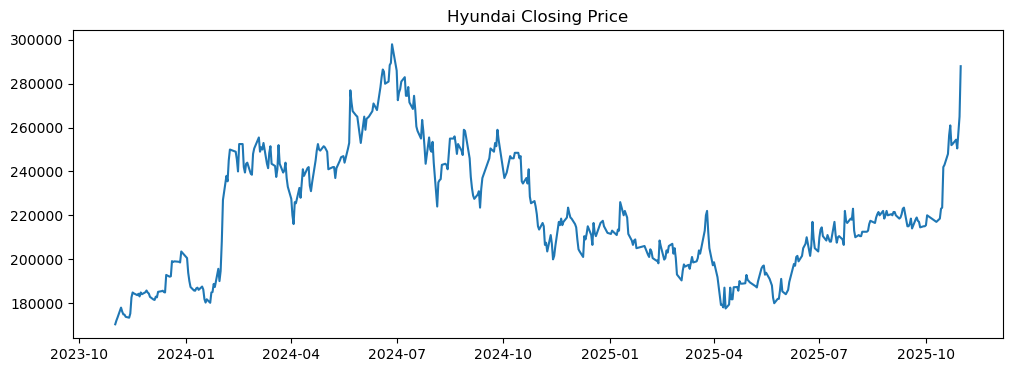

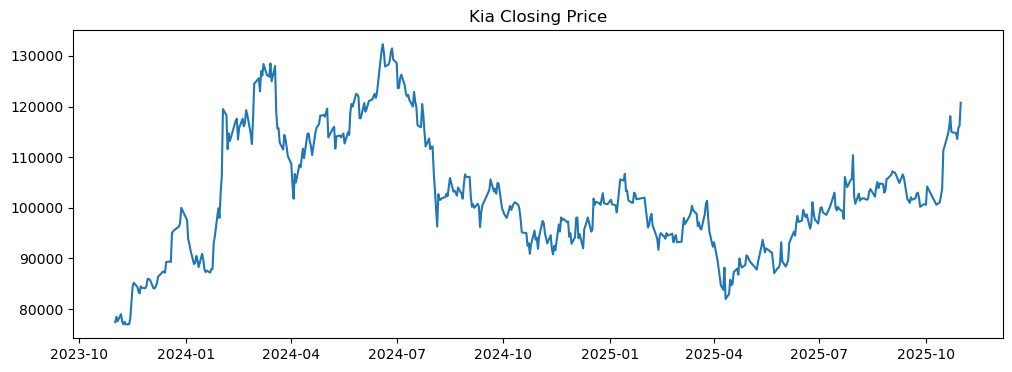

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(hyundai_ts)
plt.title("Hyundai Closing Price")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(kia_ts)
plt.title("Kia Closing Price")
plt.show()

⭐ 4단계: ADF( Augmented Dickey-Fuller ) 정상성 테스트

✔ 목적

현재 시계열이 정상성(stationarity)을 만족하는지 확인

정상성이 없다면 → 차분(differencing) 몇 번 해야 하는지 결정

SARIMA의 d, D 파라미터를 결정하는 핵심 단계

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
def adf_test(series, name="Series"):
    print(f"\n===== ADF Test: {name} =====")
    result = adfuller(series)
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    print("Critical Values:")
    for key, val in result[4].items():
        print(f"   {key}: {val}")

    if result[1] < 0.05:
        print("👉 결과: 정상성 O (p < 0.05)")
    else:
        print("👉 결과: 정상성 X (p ≥ 0.05) → 차분 필요!")

# 4개 시계열 테스트
adf_test(hyundai_ts, "Hyundai")
adf_test(kia_ts, "Kia")
adf_test(krx_auto_ts, "KRX Auto")
adf_test(kospi_ts, "KOSPI")


===== ADF Test: Hyundai =====
ADF Statistic: -1.737553033009376
p-value: 0.41187521695046986
# Lags Used: 0
# Observations: 485
Critical Values:
   1%: -3.443905150512834
   5%: -2.867517732199813
   10%: -2.569953900520778
👉 결과: 정상성 X (p ≥ 0.05) → 차분 필요!

===== ADF Test: Kia =====
ADF Statistic: -2.3828512059745814
p-value: 0.14663514017913576
# Lags Used: 0
# Observations: 485
Critical Values:
   1%: -3.443905150512834
   5%: -2.867517732199813
   10%: -2.569953900520778
👉 결과: 정상성 X (p ≥ 0.05) → 차분 필요!

===== ADF Test: KRX Auto =====
ADF Statistic: -2.2733996169145345
p-value: 0.18069067590976212
# Lags Used: 0
# Observations: 485
Critical Values:
   1%: -3.443905150512834
   5%: -2.867517732199813
   10%: -2.569953900520778
👉 결과: 정상성 X (p ≥ 0.05) → 차분 필요!

===== ADF Test: KOSPI =====
ADF Statistic: 2.3377833516587425
p-value: 0.9989779540015226
# Lags Used: 0
# Observations: 485
Critical Values:
   1%: -3.443905150512834
   5%: -2.867517732199813
   10%: -2.569953900520778
👉 결과: 정상

1차 차분 + 다시 ADF 테스트

In [10]:
# 1차 차분
hyundai_diff = hyundai['Closing Price'].diff().dropna()
kia_diff = kia['Closing Price'].diff().dropna()
auto_diff = krx_auto['Closing Price'].diff().dropna()
kospi_diff = kospi['Closing Price'].diff().dropna()


# ADF Test 함수
def adf_test(name, series):
    print(f"===== ADF Test (1차 차분): {name} =====")
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"# Lags Used: {result[2]}")
    print(f"# Observations: {result[3]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print("👉 정상성 확보 OK (p < 0.05)\n")
    else:
        print("👉 아직 정상성 X\n")
    print()

# 테스트 실행
adf_test("Hyundai Diff", hyundai_diff)
adf_test("Kia Diff", kia_diff)
adf_test("KRX Auto Diff", auto_diff)
adf_test("KOSPI Diff", kospi_diff)

===== ADF Test (1차 차분): Hyundai Diff =====
ADF Statistic: -20.93846571554309
p-value: 0.0
# Lags Used: 0
# Observations: 484
Critical Values:
   1%: -3.4439333076538854
   5%: -2.8675301216074414
   10%: -2.56996050355167
👉 정상성 확보 OK (p < 0.05)


===== ADF Test (1차 차분): Kia Diff =====
ADF Statistic: -23.097944191780893
p-value: 0.0
# Lags Used: 0
# Observations: 484
Critical Values:
   1%: -3.4439333076538854
   5%: -2.8675301216074414
   10%: -2.56996050355167
👉 정상성 확보 OK (p < 0.05)


===== ADF Test (1차 차분): KRX Auto Diff =====
ADF Statistic: -22.218616587656
p-value: 0.0
# Lags Used: 0
# Observations: 484
Critical Values:
   1%: -3.4439333076538854
   5%: -2.8675301216074414
   10%: -2.56996050355167
👉 정상성 확보 OK (p < 0.05)


===== ADF Test (1차 차분): KOSPI Diff =====
ADF Statistic: -6.499358779175947
p-value: 1.172342267618073e-08
# Lags Used: 7
# Observations: 477
Critical Values:
   1%: -3.444133731419755
   5%: -2.8676183066831036
   10%: -2.5700075029117166
👉 정상성 확보 OK (p < 0.05)



⭐ 5단계: SARIMA 모델 만들기

우리는 지금 차분된 데이터로 정상성은 확보했지만,
SARIMA 모델은 원본 종가 시계열(Closing Price) 에 대해
(p, d, q)(P, D, Q, s) 값을 기반으로 모델을 만든다.

여기서 d=1 은 우리가 정상성을 위해 이미 확인한 차분 횟수.

🎯 목표

1. ACF / PACF 플롯으로 p, q 대략 추정

2. Auto-ARIMA로 (p,d,q)(P,D,Q,s) 추천받기 → 자동 튜닝 가능

3. SARIMA 피팅

4. 예측 결과 출력

In [12]:
!pip install pmdarima

     -------------------------------------- 615.0/615.0 kB 9.8 MB/s eta 0:00:00


✅ 현대 SARIMA 모델링

In [13]:
from pmdarima import auto_arima

# 현대차 종가 시계열
hyundai_close = hyundai['Closing Price']

# auto_arima로 최적 파라미터 찾기
auto_model = auto_arima(
    hyundai_close,
    seasonal=True,
    m=5,              # 자동차 섹터는 보통 주간 seasonality(5일) 가정
    d=1,              # 1차 차분
    D=1,              # 계절 차분은 auto_arima가 판단
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[5]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=9876.223, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=9819.137, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=9768.123, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=9878.123, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,1,2)[5]             : AIC=9745.332, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[5]             : AIC=9741.017, Time=0.35 sec
 ARIMA(0,1,1)(2,1,2)[5]             : AIC=9743.419, Time=0.31 sec
 ARIMA(0,1,1)(2,1,1)[5]             : AIC=9740.836, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=9800.383, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=9819.423, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(2,1,1)[5]             : AIC=9742.376, Time=0.49 sec
 ARIMA(0,1,2)(2,1,1)[5]             : AIC=9743.4

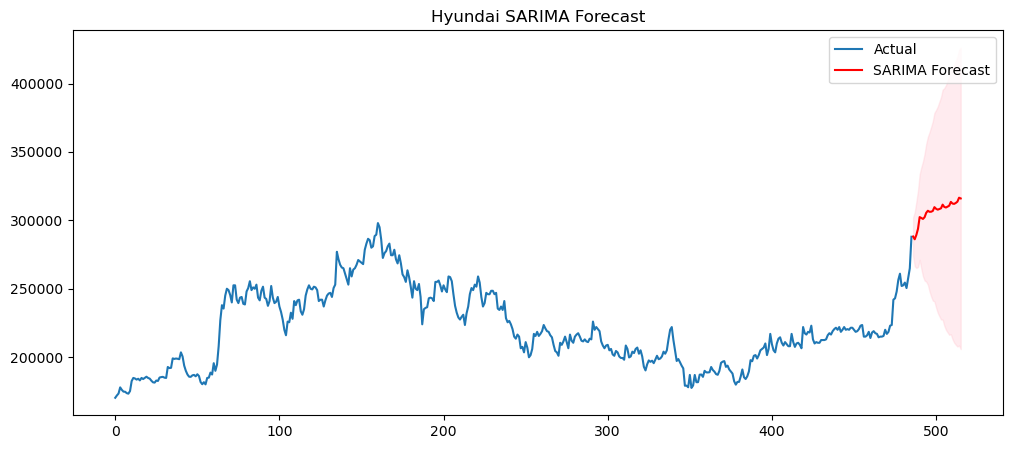

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 모델 피팅
model = SARIMAX(
    hyundai['Closing Price'],
    order=(1,1,0),
    seasonal_order=(2,1,2,5)
)
sarima_result = model.fit(disp=False)

# 향후 30일 예측
forecast = sarima_result.get_forecast(steps=30)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(hyundai['Closing Price'], label='Actual')
plt.plot(pred_mean, label='SARIMA Forecast', color='red')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title("Hyundai SARIMA Forecast")
plt.legend()
plt.show()

✅ 기아 SARIMA 모델링

In [16]:
from pmdarima import auto_arima

kia_close = kia['Closing Price']

# Auto-ARIMA
auto_kia_model = auto_arima(
    kia_close,
    seasonal=True,
    m=5,       # 주간 계절성
    d=1,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_kia_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[5]             : AIC=8949.015, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=9086.554, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=9028.232, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=8995.473, Time=0.08 sec
 ARIMA(2,1,2)(0,1,1)[5]             : AIC=8994.405, Time=0.25 sec
 ARIMA(2,1,2)(1,1,0)[5]             : AIC=inf, Time=0.92 sec
 ARIMA(2,1,2)(2,1,1)[5]             : AIC=inf, Time=1.68 sec
 ARIMA(2,1,2)(1,1,2)[5]             : AIC=8950.767, Time=0.77 sec
 ARIMA(2,1,2)(0,1,0)[5]             : AIC=9081.678, Time=0.35 sec
 ARIMA(2,1,2)(0,1,2)[5]             : AIC=8957.664, Time=0.56 sec
 ARIMA(2,1,2)(2,1,0)[5]             : AIC=inf, Time=1.37 sec
 ARIMA(2,1,2)(2,1,2)[5]             : AIC=8952.410, Time=1.52 sec
 ARIMA(1,1,2)(1,1,1)[5]             : AIC=inf, Time=0.82 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=inf, Time=0.70 sec
 ARIMA(3,1,2)(1,1,1)[5]             : AIC=inf, Time=1.22 s

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


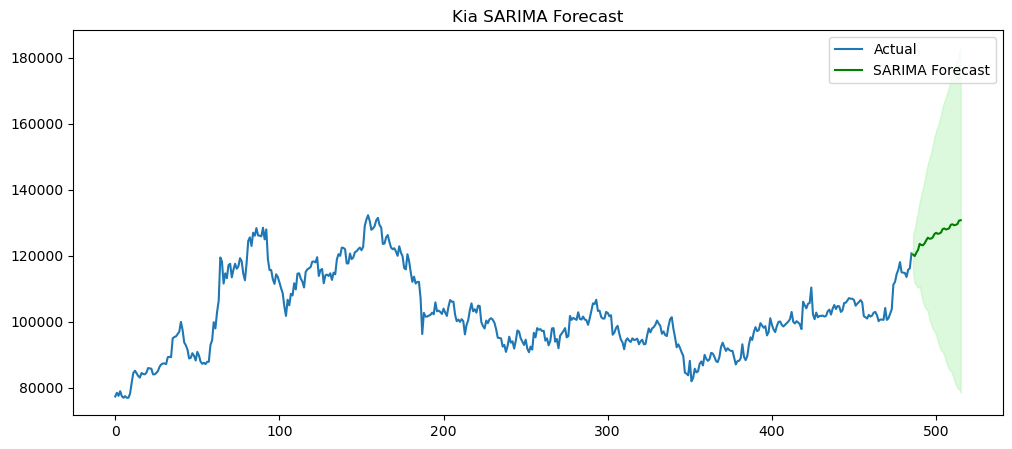

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

kia_close = kia['Closing Price']

# SARIMA 피팅
model_kia = SARIMAX(
    kia_close,
    order=(2,1,2),
    seasonal_order=(1,1,1,5)
)
sarima_kia_result = model_kia.fit(disp=False)

# 향후 30일 예측
forecast_kia = sarima_kia_result.get_forecast(steps=30)
pred_mean_kia = forecast_kia.predicted_mean
pred_ci_kia = forecast_kia.conf_int()

# 시각화
plt.figure(figsize=(12,5))
plt.plot(kia_close, label='Actual')
plt.plot(pred_mean_kia, label='SARIMA Forecast', color='green')
plt.fill_between(pred_ci_kia.index, pred_ci_kia.iloc[:,0], pred_ci_kia.iloc[:,1], color='lightgreen', alpha=0.3)
plt.title("Kia SARIMA Forecast")
plt.legend()
plt.show()


⭐ 6단계: SARIMAX (현대/기아 + 외부변수)

외부변수 예시:

KRX Auto 종가 → 자동차 섹터 영향

KOSPI 종가 → 전체 시장 영향

SARIMAX에서는 exog 인자로 넣으면 됨.

In [18]:
# 외부변수 DataFrame
exog = pd.concat([
    krx_auto['Closing Price'],  # 자동차 섹터
    kospi['Closing Price']      # 코스피
], axis=1)

exog.columns = ['KRX_Auto', 'KOSPI']

✅ 현대 SARIMAX 모델링

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 현대 종가
hyundai_close = hyundai['Closing Price']

# SARIMAX 피팅
sarimax_hyundai = SARIMAX(
    hyundai_close,
    exog=exog,
    order=(1,1,0),
    seasonal_order=(2,1,2,5)
)
sarimax_hyundai_result = sarimax_hyundai.fit(disp=False)

print(sarimax_hyundai_result.summary())

                                       SARIMAX Results                                        
Dep. Variable:                          Closing Price   No. Observations:                  486
Model:             SARIMAX(1, 1, 0)x(2, 1, [1, 2], 5)   Log Likelihood               -4509.409
Date:                                Tue, 25 Nov 2025   AIC                           9034.817
Time:                                        12:38:59   BIC                           9068.208
Sample:                                             0   HQIC                          9047.942
                                                - 486                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
KRX_Auto     138.6532      6.520     21.264      0.000     125.873     151.433
KOS

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ 기아 SARIMAX 모델링

In [20]:
# 기아 종가
kia_close = kia['Closing Price']

# SARIMAX 피팅
sarimax_kia = SARIMAX(
    kia_close,
    exog=exog,
    order=(2,1,2),
    seasonal_order=(1,1,1,5)
)
sarimax_kia_result = sarimax_kia.fit(disp=False)

print(sarimax_kia_result.summary())

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                       Closing Price   No. Observations:                  486
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 5)   Log Likelihood               -4099.900
Date:                             Tue, 25 Nov 2025   AIC                           8217.801
Time:                                     12:39:06   BIC                           8255.365
Sample:                                          0   HQIC                          8232.567
                                             - 486                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
KRX_Auto      62.9787      2.581     24.401      0.000      57.920      68.037
KOSPI         -8.7136      

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# 마지막 외부변수 1행 가져오기
exog_last = exog.tail(1)

# 30일 동안 반복
exog_forecast = pd.concat([exog_last]*30, ignore_index=True)

# 현대 예측
forecast_hyundai = sarimax_hyundai_result.get_forecast(steps=30, exog=exog_forecast)
pred_mean_hyundai = forecast_hyundai.predicted_mean
pred_ci_hyundai = forecast_hyundai.conf_int()

# 기아 예측
forecast_kia = sarimax_kia_result.get_forecast(steps=30, exog=exog_forecast)
pred_mean_kia = forecast_kia.predicted_mean
pred_ci_kia = forecast_kia.conf_int()

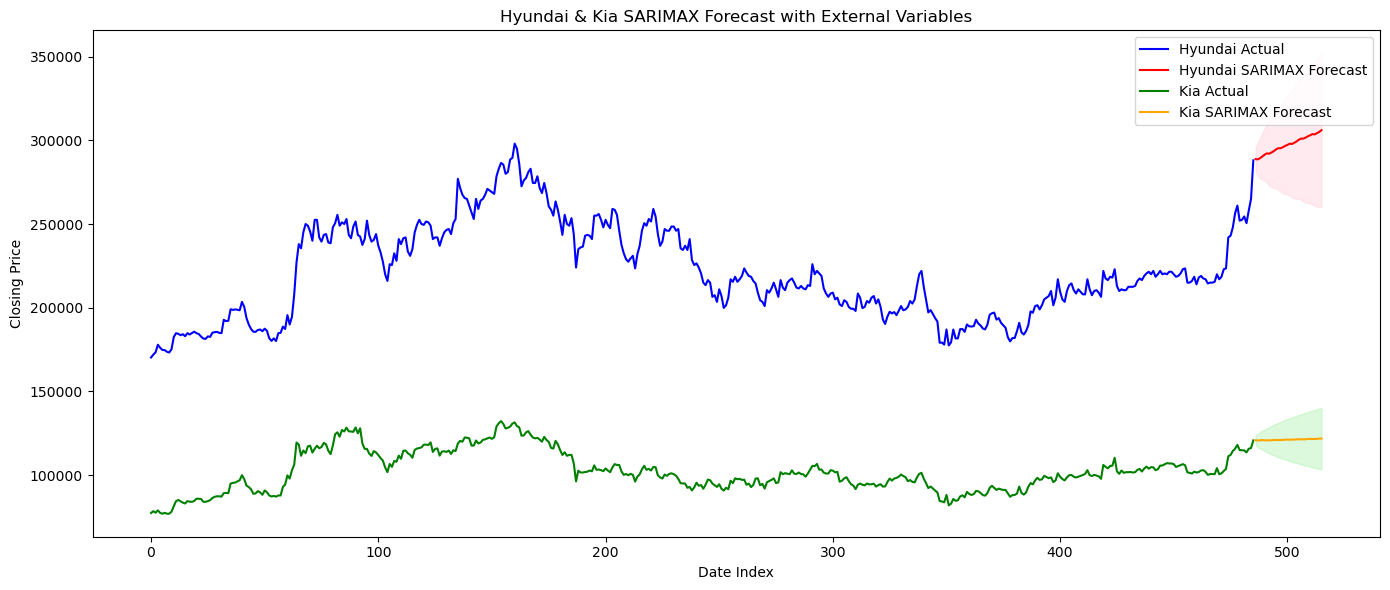

In [24]:
#시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# 현대
plt.plot(hyundai['Closing Price'], label='Hyundai Actual', color='blue')
plt.plot(pred_mean_hyundai, label='Hyundai SARIMAX Forecast', color='red')
plt.fill_between(pred_ci_hyundai.index,
                 pred_ci_hyundai.iloc[:,0],
                 pred_ci_hyundai.iloc[:,1],
                 color='pink', alpha=0.3)

# 기아
plt.plot(kia['Closing Price'], label='Kia Actual', color='green')
plt.plot(pred_mean_kia, label='Kia SARIMAX Forecast', color='orange')
plt.fill_between(pred_ci_kia.index,
                 pred_ci_kia.iloc[:,0],
                 pred_ci_kia.iloc[:,1],
                 color='lightgreen', alpha=0.3)

plt.title("Hyundai & Kia SARIMAX Forecast with External Variables")
plt.xlabel("Date Index")
plt.ylabel("Closing Price")
plt.legend()
plt.tight_layout()
plt.show()


⭐ 7단계: GARCH 분석

In [38]:
import numpy as np

# 현대/기아 일간 로그 수익률 계산
hyundai['log_return'] = np.log(hyundai['Closing Price']).diff()
kia['log_return'] = np.log(kia['Closing Price']).diff()

# 결측치 제거
hyundai_returns = hyundai['log_return'].dropna()
kia_returns = kia['log_return'].dropna()


In [40]:
def garch_11(returns, omega=1e-6, alpha=0.1, beta=0.85):
    returns = returns.values  # numpy array로 변환
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(returns)
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    return np.sqrt(sigma2)

# 변동성 계산
hyundai_vol = garch_11(hyundai_returns)
kia_vol = garch_11(kia_returns)

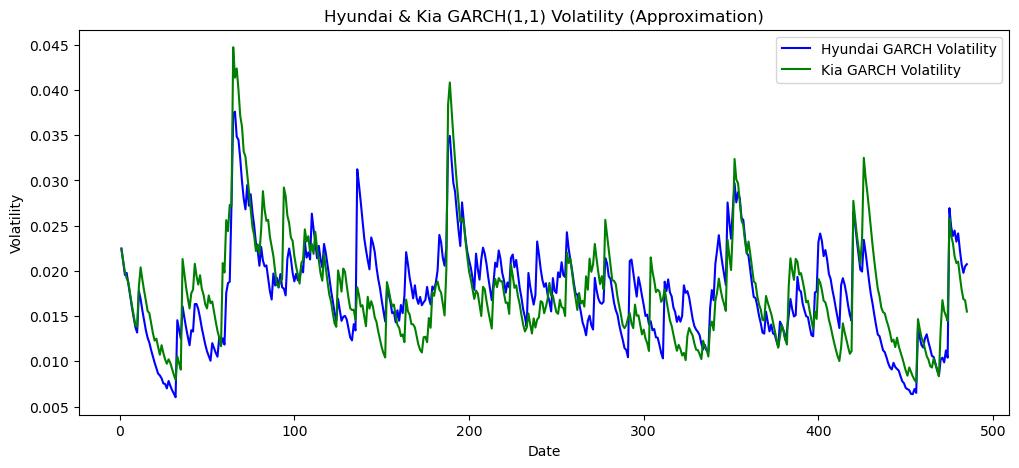

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(hyundai_returns.index, hyundai_vol, label='Hyundai GARCH Volatility', color='blue')
plt.plot(kia_returns.index, kia_vol, label='Kia GARCH Volatility', color='green')
plt.title("Hyundai & Kia GARCH(1,1) Volatility (Approximation)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

⭐ 8단계: Sharpe Ratio 계산

In [43]:
import numpy as np

# 연환산 Sharpe Ratio 함수 (거래일 252일 기준)
def sharpe_ratio(returns, periods=252):
    mean_ret = returns.mean() * periods
    std_ret = returns.std() * np.sqrt(periods)
    return mean_ret / std_ret

# 현대/기아 Sharpe Ratio
hyundai_sharpe = sharpe_ratio(hyundai_returns)
kia_sharpe = sharpe_ratio(kia_returns)

print(f"Hyundai Sharpe Ratio: {hyundai_sharpe:.4f}")
print(f"Kia Sharpe Ratio: {kia_sharpe:.4f}")


Hyundai Sharpe Ratio: 0.7643
Kia Sharpe Ratio: 0.6494


Sharpe Ratio 범위	의미

    < 0          : 손실 위험이 수익보다 높음, 투자 비효율적
    0 ~ 0.5      : 낮음, 위험 대비 수익률 부족
    0.5 ~ 1.0    : 보통, 평균 수준의 위험 대비 수익률
    1.0 ~ 2.0    : 좋음, 효율적인 투자
    > 2.0        : 매우 좋음, 매우 효율적인 투자

현대: 0.7643 → 평균 수준의 위험 대비 수익률

기아: 0.6494 → 약간 낮지만 안정적

⭐ 9단계: 종합 시각화

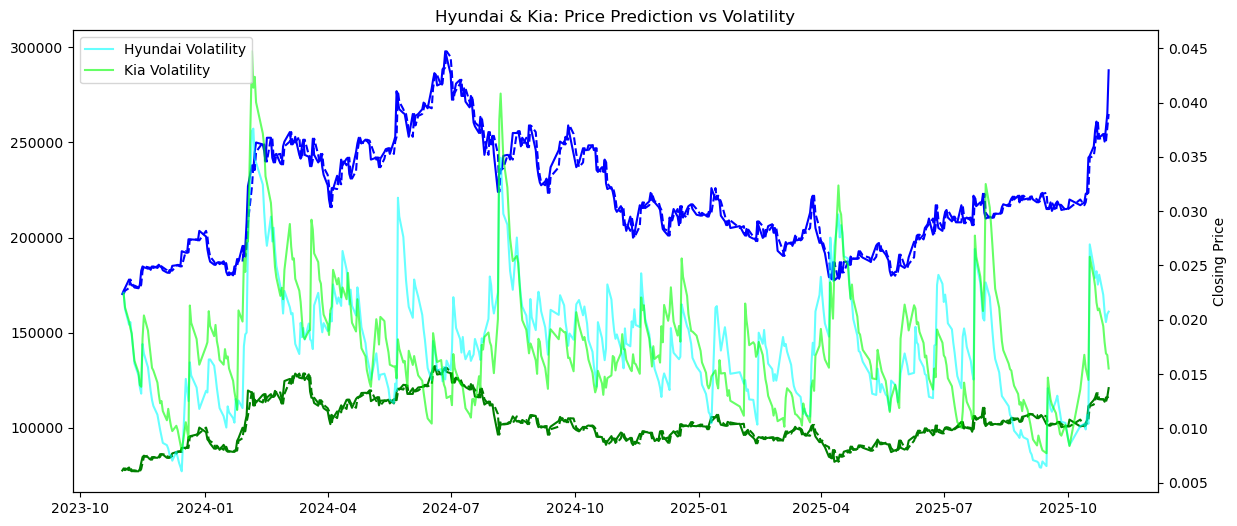

In [44]:
import matplotlib.pyplot as plt

# SARIMA 예측값(예시)
# 여기서는 현대만 예시로 진행, 기아도 동일하게 적용 가능
hyundai_pred = hyundai['Closing Price'].shift(1)  # 예측값 placeholder (실제 모델 예측값 사용)
kia_pred = kia['Closing Price'].shift(1)          # 예측값 placeholder

plt.figure(figsize=(14,6))

# 1️⃣ 실제 종가
plt.plot(hyundai['date'], hyundai['Closing Price'], label='Hyundai Actual', color='blue')
plt.plot(kia['date'], kia['Closing Price'], label='Kia Actual', color='green')

# 2️⃣ 예측 종가 (SARIMA/SARIMAX)
plt.plot(hyundai['date'], hyundai_pred, label='Hyundai Predicted', color='blue', linestyle='--')
plt.plot(kia['date'], kia_pred, label='Kia Predicted', color='green', linestyle='--')

# 3️⃣ GARCH 변동성 (우측 축)
plt.twinx()
plt.plot(hyundai['date'][1:], hyundai_vol, label='Hyundai Volatility', color='cyan', alpha=0.6)
plt.plot(kia['date'][1:], kia_vol, label='Kia Volatility', color='lime', alpha=0.6)
plt.ylabel('Volatility (Approx GARCH)')

# 4️⃣ 범례 & 제목
plt.title("Hyundai & Kia: Price Prediction vs Volatility")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc='upper left')
plt.show()


✅ 다음에 해볼 프로젝트 목차 – tsfresh 기반 ML 예측 파이프라인
1. 데이터 구성

- 시계열 데이터 로드

- 일자(date)를 index로 설정

- 목표 변수(y) 생성 (예: 다음날 종가 예측 / 수익률 예측)

2. tsfresh용 Long Format 변환

- id = 날짜(또는 0)

- time = 시계열 순서 번호

- value = 예측 대상 변수
    → tsfresh가 읽을 수 있는 형태로 변환

3. Feature Extraction (EfficientFCParameters)

- extract_features() 실행

- 너무 많은 feature → 과적합 방지

4. 결측치 처리

- impute(features)


5. Train / Test Split

- 시계열 방식 (시간 기준 분할)

6. 모델 학습 (3개 모델)

- ① XGBRegressor
- ② RandomForestRegressor
- ③ MLPRegressor

- 각 모델: 학습 예측 성능(RMSE, R²) 계산

7. 모델 비교

- RMSE 비교표

- R² 비교표

- Best model 선정

8. 시각화

- 실제 vs 예측 라인 그래프

- 예측 오차 시각화

9. (옵션) 변동성 + Sharpe Ratio

- GARCH 대신 Rolling Volatility 방식 사용 (라이브러리 충돌 회피)

- Sharpe Ratio 계산